In [70]:
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

In [71]:
import re

def normalize_negations(text):
    text = text.lower()
    text = re.sub(r"\b(dont|don't)\b", "do not", text)
    text = re.sub(r"\b(doesnt|doesn't)\b", "does not", text)
    text = re.sub(r"\b(didnt|didn't)\b", "did not", text)
    text = re.sub(r"\b(cant|can't)\b", "cannot", text)
    text = re.sub(r"\b(wont|won't)\b", "will not", text)
    text = re.sub(r"\b(isnt|isn't)\b", "is not", text)
    text = re.sub(r"\b(arent|aren't)\b", "are not", text)
    text = re.sub(r"\b(wasnt|wasn't)\b", "was not", text)
    text = re.sub(r"\b(werent|weren't)\b", "were not", text)
    text = re.sub(r"\b(couldnt|couldn't)\b", "could not", text)
    text = re.sub(r"\b(shouldnt|shouldn't)\b", "should not", text)
    text = re.sub(r"\b(wouldnt|wouldn't)\b", "would not", text)
    text = re.sub(r"\b(havent|haven't)\b", "have not", text)
    text = re.sub(r"\b(hasnt|hasn't)\b", "has not", text)
    text = re.sub(r"\b(hadnt|hadn't)\b", "had not", text)

    tokens = re.findall(r"[a-z]+", text)
    negators = {"not", "no", "never", "cannot"}
    out = []
    negate_next = False

    for tok in tokens:
        if tok in negators:
            negate_next = True
            out.append(tok)
            continue
        if negate_next:
            out.append(f"not_{tok}")
            negate_next = False
        else:
            out.append(tok)

    return " ".join(out)

In [72]:
df = pd.read_csv('enhanced_reviews_dataset.csv')

In [73]:
df['review_text'] = df['review_text'].apply(normalize_negations)

In [74]:
df.sample()

,review_text,sentiment,rating,num_words,num_chars,num_sentences,avg_word_length,length_category,negation_count,lexical_diversity,digit_ratio,special_char_ratio
31741,serves its purpose i needed a visual aide for ...,Positive,4.0,59,66,3,4.457627,Medium,3,0.830508,0.0,0.021807


In [75]:
x_train, x_test, y_train, y_test = train_test_split(
    df['review_text'], df['sentiment'], test_size=0.2, random_state=42
)

x_train = x_train.map(normalize_negations)
x_test = x_test.map(normalize_negations)

train_indices = x_train.index
test_indices = x_test.index

In [76]:
tfidf = TfidfVectorizer(
    max_features=4500, 
    # stop_words='english',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2),
    lowercase=True,
    sublinear_tf=True
    )

X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

In [77]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

tried different-different columns

In [78]:
# from scipy.sparse import hstack
# from scipy.sparse import csr_matrix

# length_category_train = le.fit_transform(df.loc[train_indices, 'length_category'])
# length_category_test = le.transform(df.loc[test_indices, 'length_category'])


# X_train_numerical = np.column_stack([
# 	df.loc[train_indices, 'negation_count'].values,
# 	length_category_train
# ]).astype(np.float64)

# X_test_numerical = np.column_stack([
# 	df.loc[test_indices, 'negation_count'].values,
# 	length_category_test
# ]).astype(np.float64)


# X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_numerical)])
# X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_numerical)])

In [79]:
X_train_combined = X_train_tfidf
X_test_combined = X_test_tfidf

In [80]:
lr = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

In [81]:
lr.fit(X_train_combined, y_train_encoded)
mnb.fit(X_train_combined, y_train_encoded)
bnb.fit(X_train_combined, y_train_encoded)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"binarize binarize: float or None, default=0.0Threshold for binarizing (mapping to booleans) of sample features.If None, input is presumed to already consist of binary vectors.",0.0
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [82]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc)

In [83]:
res = {}

In [84]:
y_pred_lr = lr.predict(X_test_combined)
y_pred_proba_lr = lr.predict_proba(X_test_combined)

res['LogisticRegression'] = {
     'accuracy': accuracy_score(y_test_encoded, y_pred_lr),
    'precision': precision_score(y_test_encoded, y_pred_lr, average='weighted', zero_division=0),
    'recall': recall_score(y_test_encoded, y_pred_lr, average='weighted', zero_division=0),
    'f1-score': f1_score(y_test_encoded, y_pred_lr, average='weighted', zero_division=0),
    'predictions': y_pred_lr,
    'probabilities': y_pred_proba_lr
}

In [85]:
y_pred_mnb = mnb.predict(X_test_combined)
y_pred_proba_mnb = mnb.predict_proba(X_test_combined)

res['MultinomialNB'] = {
    'accuracy': accuracy_score(y_test_encoded, y_pred_mnb),
    'precision': precision_score(y_test_encoded, y_pred_mnb, average='weighted', zero_division=0),
    'recall': recall_score(y_test_encoded, y_pred_mnb, average='weighted', zero_division=0),
    'f1-score': f1_score(y_test_encoded, y_pred_mnb, average='weighted', zero_division=0),
    'predictions': y_pred_mnb,
    'probabilities': y_pred_proba_mnb
}

In [86]:
y_pred_bnb = bnb.predict(X_test_combined)
y_pred_proba_bnb = bnb.predict_proba(X_test_combined)

res['BernoulliNB'] = {
    'accuracy': accuracy_score(y_test_encoded, y_pred_bnb),
    'precision': precision_score(y_test_encoded, y_pred_bnb, average='weighted', zero_division=0),
    'recall': recall_score(y_test_encoded, y_pred_bnb, average='weighted', zero_division=0),
    'f1-score': f1_score(y_test_encoded, y_pred_bnb, average='weighted', zero_division=0),
    'predictions': y_pred_bnb,
    'probabilities': y_pred_proba_bnb
}

In [87]:
metric_df = pd.DataFrame(res).T[['accuracy', 'precision', 'recall', 'f1-score']] * 100

In [88]:
metric_df

,accuracy,precision,recall,f1-score
LogisticRegression,88.026446,86.786323,88.026446,87.046952
MultinomialNB,85.101573,83.942999,85.101573,82.467654
BernoulliNB,71.976031,77.600611,71.976031,74.300046


In [89]:
# Evaluation on TRAINING set
y_train_pred_lr = lr.predict(X_train_combined)
y_train_pred_mnb = mnb.predict(X_train_combined)
y_train_pred_bnb = bnb.predict(X_train_combined)

train_scores = {
    'LogisticRegression': {
        'accuracy': accuracy_score(y_train_encoded, y_train_pred_lr),
        'precision': precision_score(y_train_encoded, y_train_pred_lr, average='weighted', zero_division=0),
        'recall': recall_score(y_train_encoded, y_train_pred_lr, average='weighted', zero_division=0),
        'f1-score': f1_score(y_train_encoded, y_train_pred_lr, average='weighted', zero_division=0)
    },
    'MultinomialNB': {
        'accuracy': accuracy_score(y_train_encoded, y_train_pred_mnb),
        'precision': precision_score(y_train_encoded, y_train_pred_mnb, average='weighted', zero_division=0),
        'recall': recall_score(y_train_encoded, y_train_pred_mnb, average='weighted', zero_division=0),
        'f1-score': f1_score(y_train_encoded, y_train_pred_mnb, average='weighted', zero_division=0)
    },
    'BernoulliNB': {
        'accuracy': accuracy_score(y_train_encoded, y_train_pred_bnb),
        'precision': precision_score(y_train_encoded, y_train_pred_bnb, average='weighted', zero_division=0),
        'recall': recall_score(y_train_encoded, y_train_pred_bnb, average='weighted', zero_division=0),
        'f1-score': f1_score(y_train_encoded, y_train_pred_bnb, average='weighted', zero_division=0)
    }
}

train_metric_df = pd.DataFrame(train_scores).T[['accuracy', 'precision', 'recall', 'f1-score']] * 100

print("="*70)
print("TRAINING SET PERFORMANCE:")
print("="*70)
print(train_metric_df)
print("\n" + "="*70)
print("TEST SET PERFORMANCE:")
print("="*70)
print(metric_df)
print("\n" + "="*70)
print("OVERFITTING CHECK (Train - Test Accuracy %):")
print("="*70)

for model in train_metric_df.index:
    train_acc = train_metric_df.loc[model, 'accuracy']
    test_acc = metric_df.loc[model, 'accuracy']
    gap = train_acc - test_acc
    print(f"{model:20s}: Train={train_acc:6.2f}%  Test={test_acc:6.2f}%  Gap={gap:6.2f}%")
    if gap > 5:
        print(f"Possible overfitting detected (gap > 5%)")
    elif gap > 10:
        print(f"overfitting detected (gap > 10%)")
    else:
        print(f"Good generalization")

TRAINING SET PERFORMANCE:
                     accuracy  precision     recall   f1-score
LogisticRegression  88.926265  87.904667  88.926265  88.032512
MultinomialNB       85.207020  84.081281  85.207020  82.622699
BernoulliNB         72.007726  77.396876  72.007726  74.245827

TEST SET PERFORMANCE:
                     accuracy  precision     recall   f1-score
LogisticRegression  88.026446  86.786323  88.026446  87.046952
MultinomialNB       85.101573  83.942999  85.101573  82.467654
BernoulliNB         71.976031  77.600611  71.976031  74.300046

OVERFITTING CHECK (Train - Test Accuracy %):
LogisticRegression  : Train= 88.93%  Test= 88.03%  Gap=  0.90%
Good generalization
MultinomialNB       : Train= 85.21%  Test= 85.10%  Gap=  0.11%
Good generalization
BernoulliNB         : Train= 72.01%  Test= 71.98%  Gap=  0.03%
Good generalization


best Model Logistic regression

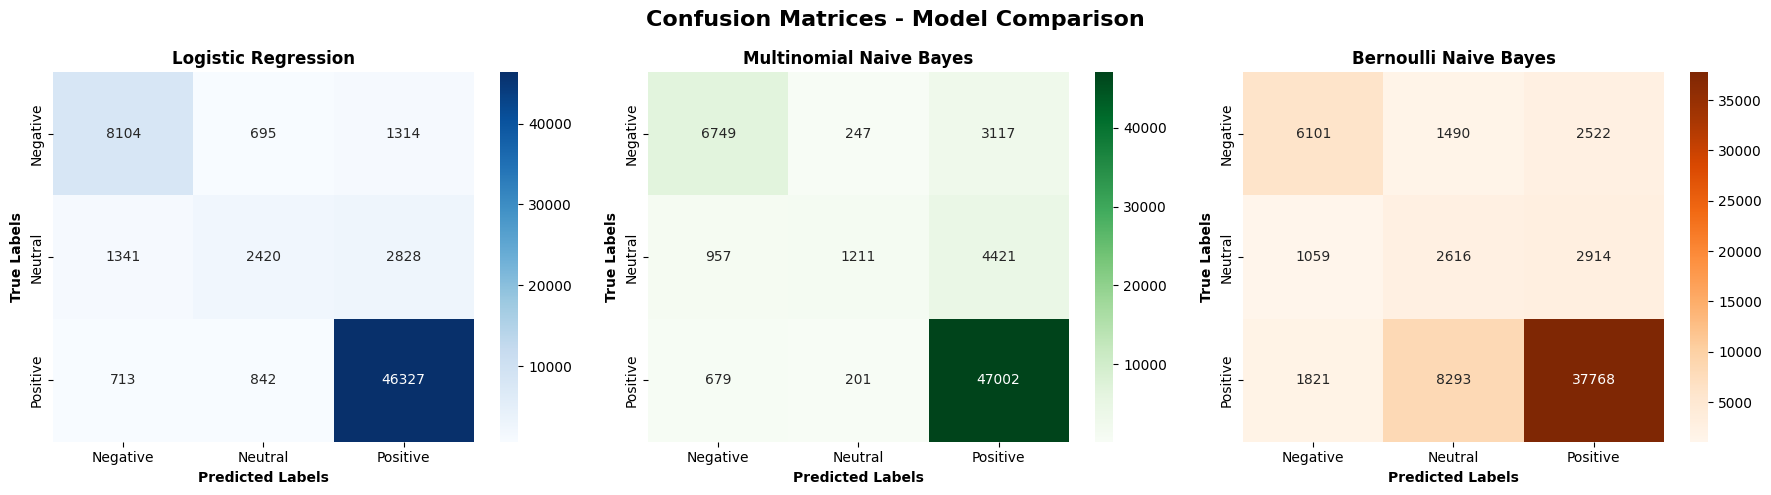

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Model Comparison', fontsize=16, fontweight='bold')

# Get sentiment labels from original y_test
sentiment_labels = sorted(y_test.unique())

# lr
df_cm_lr = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred_lr),
                        index=sentiment_labels,
                        columns=sentiment_labels)
sns.heatmap(df_cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=True)
axes[0].set_xlabel('Predicted Labels', fontweight='bold')
axes[0].set_ylabel('True Labels', fontweight='bold')
axes[0].set_title('Logistic Regression', fontweight='bold')


# mnb
df_cm_mnb = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred_mnb),
                         index=sentiment_labels,
                         columns=sentiment_labels)
sns.heatmap(df_cm_mnb, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=True)
axes[1].set_xlabel('Predicted Labels', fontweight='bold')
axes[1].set_ylabel('True Labels', fontweight='bold')
axes[1].set_title('Multinomial Naive Bayes', fontweight='bold')


# bnb
df_cm_bnb = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred_bnb),
                         index=sentiment_labels,
                         columns=sentiment_labels)
sns.heatmap(df_cm_bnb, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=True)
axes[2].set_xlabel('Predicted Labels', fontweight='bold')
axes[2].set_ylabel('True Labels', fontweight='bold')
axes[2].set_title('Bernoulli Naive Bayes', fontweight='bold')
plt.tight_layout()
plt.savefig('pictorial_metrics&model_evaluation/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

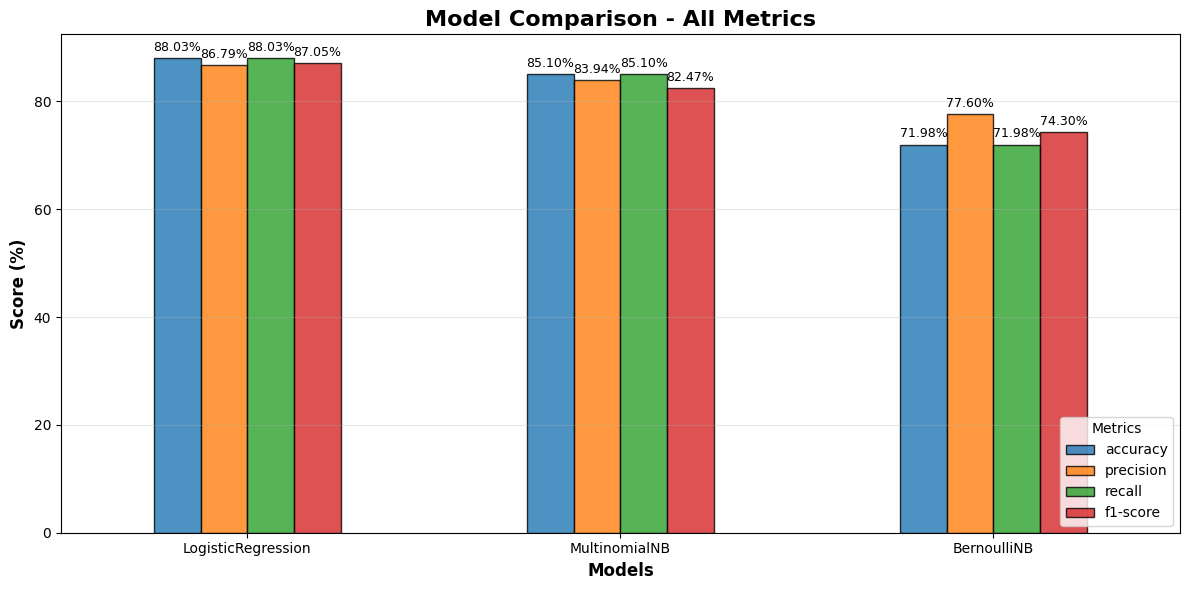

In [92]:
ax = metric_df.plot(kind='bar', figsize=(12, 6), rot=0, alpha=0.8, edgecolor='black')
plt.title('Model Comparison - All Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.legend(title='Metrics', loc='lower right')
plt.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('pictorial_metrics&model_evaluation/Models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [93]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [94]:
models_auc = []

for model_name, probas in [
    ('Logistic Regression', y_pred_proba_lr),
    ('Multinomial NB', y_pred_proba_mnb),
    ('Bernoulli NB', y_pred_proba_bnb)
]:
    try:
        macro_auc = roc_auc_score(y_test_encoded, probas, multi_class='ovr', average='macro')
        weighted_auc = roc_auc_score(y_test_encoded, probas, multi_class='ovr', average='weighted')
        
        print(f"\n{model_name}:")
        print(f"* Macro AUC (One-vs-Rest):    {macro_auc:.4f}")
        print(f"* Weighted AUC (One-vs-Rest): {weighted_auc:.4f}")
        
        models_auc.append({
            'model': model_name,
            'macro_auc': macro_auc,
            'weighted_auc': weighted_auc
        })
    except:
        pass




Logistic Regression:
* Macro AUC (One-vs-Rest):    0.9458
* Weighted AUC (One-vs-Rest): 0.9592

Multinomial NB:
* Macro AUC (One-vs-Rest):    0.9261
* Weighted AUC (One-vs-Rest): 0.9409

Bernoulli NB:
* Macro AUC (One-vs-Rest):    0.8338
* Weighted AUC (One-vs-Rest): 0.8346


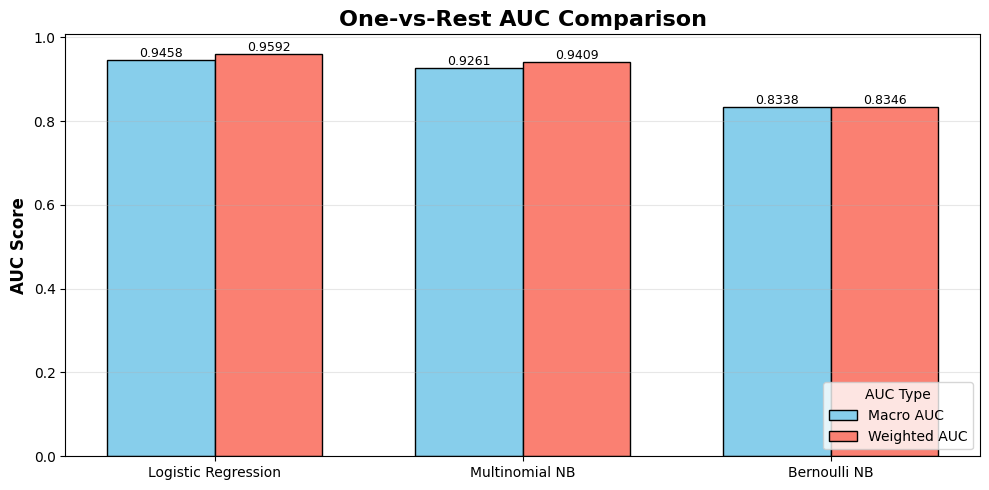

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))

model_names = [m['model'] for m in models_auc]
macro_aucs = [m['macro_auc'] for m in models_auc]
weighted_aucs = [m['weighted_auc'] for m in models_auc]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, macro_aucs, width, label='Macro AUC', color='skyblue', edgecolor='black')
ax.bar(x + width/2, weighted_aucs, width, label='Weighted AUC', color='salmon', edgecolor='black')

ax.set_title('One-vs-Rest AUC Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=12, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=10)

ax.legend(title='AUC Type', loc='lower right')
ax.grid(axis='y', alpha=0.3)

for i in range(len(model_names)):
    ax.text(x[i] - width/2, macro_aucs[i], f"{macro_aucs[i]:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width/2, weighted_aucs[i], f"{weighted_aucs[i]:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('pictorial_metrics&model_evaluation/model_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = lr.coef_[0][:len(feature_names)]

top_indices = np.argsort(coefficients)[-15:]  # Top 15 positive
bottom_indices = np.argsort(coefficients)[:15]  # Bottom 15 negative

In [97]:
coefficients = lr.coef_[0][:len(feature_names)]

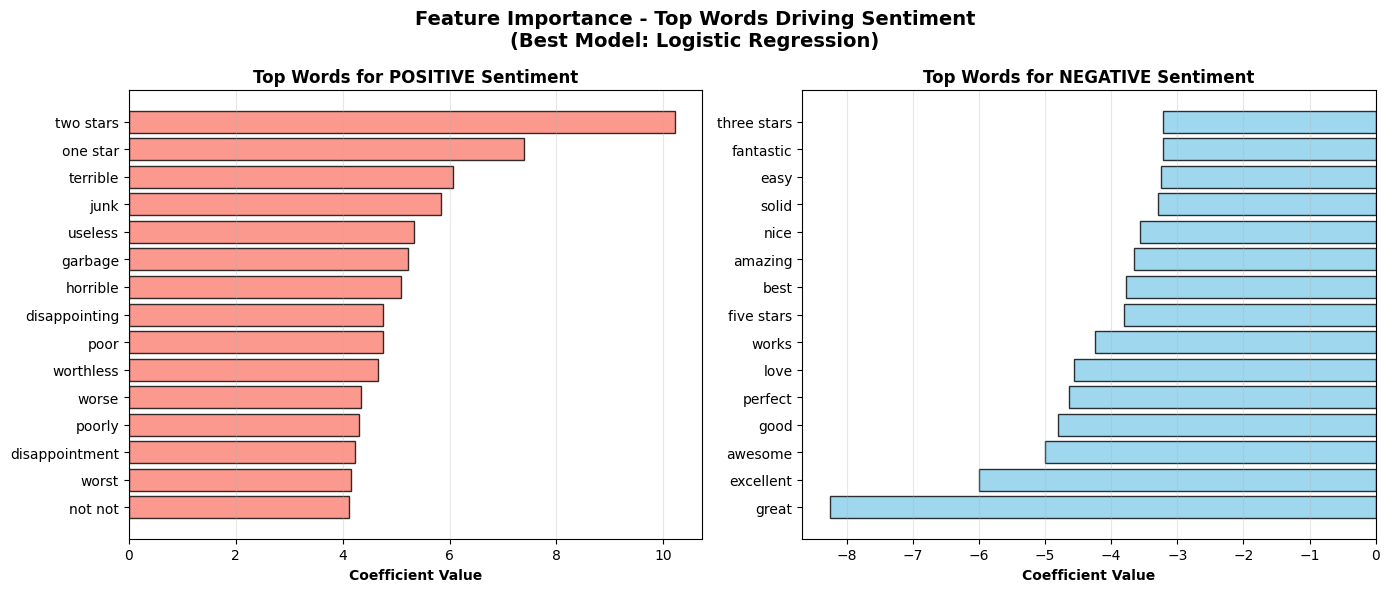

In [98]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Feature Importance - Top Words Driving Sentiment\n(Best Model: Logistic Regression)', 
             fontsize=14, fontweight='bold')

# Positive sentiment features
top_features = feature_names[top_indices]
top_values = coefficients[top_indices]

axes[0].barh(range(len(top_features)), top_values, color='salmon', alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features, fontsize=10)
axes[0].set_xlabel('Coefficient Value', fontweight='bold')
axes[0].set_title('Top Words for POSITIVE Sentiment', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Negative sentiment features
bottom_features = feature_names[bottom_indices]
bottom_values = coefficients[bottom_indices]

axes[1].barh(range(len(bottom_features)), bottom_values, color='skyblue', alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(bottom_features)))
axes[1].set_yticklabels(bottom_features, fontsize=10)
axes[1].set_xlabel('Coefficient Value', fontweight='bold')
axes[1].set_title('Top Words for NEGATIVE Sentiment', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('pictorial_metrics&model_evaluation/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [99]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [100]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs','saga']
}


In [101]:
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(
    LogisticRegression(max_iter=500, random_state=42, solver='saga'), 
    param_distributions=param_grid,
    cv=5,
    scoring='accuracy',
    n_iter=10, 
    n_jobs=-1,
    verbose=1,
    random_state=42
)
grid.fit(X_train_tfidf, y_train_encoded)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")


best_lr = grid.best_estimator_
y_pred_best = best_lr.predict(X_test_tfidf)

print("="*70)

print(f"IMPROVED MODEL PERFORMANCE:")
print(f"* Accuracy: {accuracy_score(y_test_encoded, y_pred_best):.4f}")
print(f"* Precision: {precision_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"* Recall: {recall_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"* F1-Score: {f1_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 1}
Best CV Accuracy: 0.8800
IMPROVED MODEL PERFORMANCE:
* Accuracy: 0.8801
* Precision: 0.8674
* Recall: 0.8801
* F1-Score: 0.8700


In [102]:
# original vs tuned
original_f1 = res['LogisticRegression']['f1-score']
tuned_f1 = f1_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0)

print("IMPROVEMENT ANALYSIS:")
print(f"* Original F1-Score: {original_f1:.4f}")
print(f"* Tuned F1-Score: {tuned_f1:.4f}")
print(f"* Change: {(tuned_f1 - original_f1):.4f}")

if tuned_f1 > original_f1:
    improvement_pct = ((tuned_f1 - original_f1) / original_f1) * 100
    print(f"* Improvement: +{improvement_pct:.2f}%")
else:
    print(f"* Original model performs better - keeping original")


IMPROVEMENT ANALYSIS:
* Original F1-Score: 0.8705
* Tuned F1-Score: 0.8700
* Change: -0.0005
* Original model performs better - keeping original


In [103]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42, solver='saga'),
    param_grid= param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_tfidf, y_train_encoded)

print(f"* Best Parameters: {grid.best_params_}")
print(f"* Best CV Accuracy: {grid.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
* Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
* Best CV Accuracy: 0.8800


In [104]:
# training model with best parameters
best_lr = grid.best_estimator_
y_pred_best = best_lr.predict(X_test_tfidf)

print(f"IMPROVED MODEL PERFORMANCE:")
print(f"* Accuracy: {accuracy_score(y_test_encoded, y_pred_best):.4f}")
print(f"* Precision: {precision_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"* Recall: {recall_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"* F1-Score: {f1_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0):.4f}")

IMPROVED MODEL PERFORMANCE:
* Accuracy: 0.8801
* Precision: 0.8674
* Recall: 0.8801
* F1-Score: 0.8700


In [105]:
# Compare original vs tuned
original_f1 = res['LogisticRegression']['f1-score']
tuned_f1 = f1_score(y_test_encoded, y_pred_best, average='weighted', zero_division=0)

print("IMPROVEMENT ANALYSIS:")
print(f"* Original F1-Score: {original_f1:.4f}")
print(f"* Tuned F1-Score: {tuned_f1:.4f}")
print(f"* Change: {(tuned_f1 - original_f1):.4f}")

if tuned_f1 > original_f1:
    improvement_pct = ((tuned_f1 - original_f1) / original_f1) * 100
    print(f"* Improvement: +{improvement_pct:.2f}%")
else:
    print(f"* Original model performs better - keeping original")


IMPROVEMENT ANALYSIS:
* Original F1-Score: 0.8705
* Tuned F1-Score: 0.8700
* Change: -0.0005
* Original model performs better - keeping original


# model_deployement_pipeline

In [106]:
import re

def normalize_negations(text):
    text = text.lower()
    text = re.sub(r"\b(dont|don't)\b", "do not", text)
    text = re.sub(r"\b(doesnt|doesn't)\b", "does not", text)
    text = re.sub(r"\b(didnt|didn't)\b", "did not", text)
    text = re.sub(r"\b(cant|can't)\b", "cannot", text)
    text = re.sub(r"\b(wont|won't)\b", "will not", text)
    text = re.sub(r"\b(isnt|isn't)\b", "is not", text)
    text = re.sub(r"\b(arent|aren't)\b", "are not", text)
    text = re.sub(r"\b(wasnt|wasn't)\b", "was not", text)
    text = re.sub(r"\b(werent|weren't)\b", "were not", text)
    text = re.sub(r"\b(couldnt|couldn't)\b", "could not", text)
    text = re.sub(r"\b(shouldnt|shouldn't)\b", "should not", text)
    text = re.sub(r"\b(wouldnt|wouldn't)\b", "would not", text)
    text = re.sub(r"\b(havent|haven't)\b", "have not", text)
    text = re.sub(r"\b(hasnt|hasn't)\b", "has not", text)
    text = re.sub(r"\b(hadnt|hadn't)\b", "had not", text)

    tokens = re.findall(r"[a-z]+", text)
    negators = {"not", "no", "never", "cannot"}
    out = []
    negate_next = False

    for tok in tokens:
        if tok in negators:
            negate_next = True
            out.append(tok)
            continue
        if negate_next:
            out.append(f"not_{tok}")
            negate_next = False
        else:
            out.append(tok)

    return " ".join(out)

In [107]:
class SentimentPredictor:
    def __init__(self, model, vectorizer, label_encoder):
        self.model = model
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder

    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        texts = [normalize_negations(text) for text in texts]

        X_tfidf = self.vectorizer.transform(texts)
        pred = self.model.predict(X_tfidf)
        return self.label_encoder.inverse_transform(pred)

In [114]:
import re

class SentimentPipeline:
    
    def __init__(self, model, vectorizer, label_encoder):
        self.model = model
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
    
    @staticmethod
    def normalize_negations(text):

        text = text.lower()

        text = re.sub(r"\b(dont|don't)\b", "do not", text)
        text = re.sub(r"\b(doesnt|doesn't)\b", "does not", text)
        text = re.sub(r"\b(didnt|didn't)\b", "did not", text)
        text = re.sub(r"\b(cant|can't)\b", "cannot", text)
        text = re.sub(r"\b(wont|won't)\b", "will not", text)
        text = re.sub(r"\b(isnt|isn't)\b", "is not", text)
        text = re.sub(r"\b(arent|aren't)\b", "are not", text)
        text = re.sub(r"\b(wasnt|wasn't)\b", "was not", text)
        text = re.sub(r"\b(werent|weren't)\b", "were not", text)
        text = re.sub(r"\b(couldnt|couldn't)\b", "could not", text)
        text = re.sub(r"\b(shouldnt|shouldn't)\b", "should not", text)
        text = re.sub(r"\b(wouldnt|wouldn't)\b", "would not", text)
        text = re.sub(r"\b(havent|haven't)\b", "have not", text)
        text = re.sub(r"\b(hasnt|hasn't)\b", "has not", text)
        text = re.sub(r"\b(hadnt|hadn't)\b", "had not", text)

        tokens = re.findall(r"[a-z]+", text)
        negators = {"not", "no", "never", "cannot"}
        out = []
        negate_next = False

        for tok in tokens:
            if tok in negators:
                negate_next = True
                out.append(tok)
                continue
            if negate_next:
                out.append(f"not_{tok}")
                negate_next = False
            else:
                out.append(tok)

        return " ".join(out)

    def _validate(self):
        if self.model is None or self.vectorizer is None or self.label_encoder is None:
            raise ValueError("model, vectorizer, and label_encoder must be set")

        checks = [
            ("vectorizer", self.vectorizer, "vocabulary_"),
            ("model", self.model, "classes_"),
            ("label_encoder", self.label_encoder, "classes_")
        ]
        
        for name, obj, attr in checks:
            if not hasattr(obj, attr):
                raise ValueError(f"{name} does not appear to be fitted")

    def _prepare_texts(self, texts, normalize=True):
        if texts is None:
            raise ValueError("texts cannot be None")

        single = False
        if isinstance(texts, str):
            texts = [texts]
            single = True
        elif not isinstance(texts, (list, tuple)):
            raise TypeError("texts must be a string or a list of strings")

        cleaned = []
        for text in texts:
            if text is None:
                cleaned.append("")
                continue
            text = str(text)
            cleaned.append(self.normalize_negations(text) if normalize else text)

        return cleaned, single

    def predict(self, texts, normalize=True, return_single=False):
        self._validate()
        cleaned, single = self._prepare_texts(texts, normalize)
        
        if len(cleaned) == 0:
            return "" if (return_single and single) else []

        X_tfidf = self.vectorizer.transform(cleaned)
        pred = self.model.predict(X_tfidf)
        labels = self.label_encoder.inverse_transform(pred)

        if return_single and single:
            return labels[0]
        return list(labels)

    def predict_proba(self, texts, normalize=True):
        self._validate()
        if not hasattr(self.model, "predict_proba"):
            raise AttributeError("model does not support predict_proba")

        cleaned, _ = self._prepare_texts(texts, normalize)
        if len(cleaned) == 0:
            return []

        X_tfidf = self.vectorizer.transform(cleaned)
        return self.model.predict_proba(X_tfidf)

def normalize_negations(text):
    return SentimentPipeline.normalize_negations(text)

In [ ]:
sentiment_pipeline = SentimentPipeline(best_lr, tfidf, le)
# sentiment_pipeline = SentimentPipeline(lr, tfidf, le)

test_reviews = [
    "This product is bad! I will not it buy again.",
    "I hate this, never buying again",
    "Amazing product! Highly recommend it",
    "I love this, best purchase ever",
    "not good at all",
    "doesnt work as expected",
]


predictions = sentiment_pipeline.predict(test_reviews)


for i, (review, sentiment) in enumerate(zip(test_reviews, predictions), 1):
    print(f"\n{i:2d}. Review: {review}")
    print(f" Prediction: {sentiment}")


 1. Review: This product is bad! I will not it buy again.
 Prediction: Negative

 2. Review: I hate this, never buying again
 Prediction: Negative

 3. Review: Amazing product! Highly recommend it
 Prediction: Positive

 4. Review: I love this, best purchase ever
 Prediction: Positive

 5. Review: not good at all
 Prediction: Negative

 6. Review: doesnt work as expected
 Prediction: Negative


In [116]:
import joblib
joblib.dump(sentiment_pipeline, 'sentiment_pipeline.pkl')


['sentiment_pipeline.pkl']